In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as mobilenet_v3_preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [18]:
# --- Konstanta dan Path Dataset ---
BASE_DIR = 'dataset/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# --- Path Penyimpanan Hasil ---
RESULTS_BASE_DIR = 'results'
GRAPH_BASELINE_DIR = os.path.join(RESULTS_BASE_DIR, 'graph/baseline')
MODEL_BASELINE_DIR = os.path.join(RESULTS_BASE_DIR, 'model/baseline')

# Buat direktori penyimpanan jika belum ada
os.makedirs(GRAPH_BASELINE_DIR, exist_ok=True)
os.makedirs(MODEL_BASELINE_DIR, exist_ok=True)
print(f"Direktori grafik akan disimpan di: {GRAPH_BASELINE_DIR}")
print(f"Direktori model akan disimpan di: {MODEL_BASELINE_DIR}")

# --- Kelas dari dataset ---
try:
    CLASSES = sorted(os.listdir(TRAIN_DIR))
    NUM_CLASSES = len(CLASSES)
    if NUM_CLASSES == 0:
        raise ValueError(f"Tidak ada direktori kelas yang ditemukan di {TRAIN_DIR}.")
    print(f"Kelas yang ditemukan: {CLASSES}")
    print(f"Jumlah kelas: {NUM_CLASSES}")
except FileNotFoundError:
    print(f"Error: Direktori '{TRAIN_DIR}' tidak ditemukan. Harap periksa path dataset Anda.")
    raise
except ValueError as ve:
    print(f"Error: {ve}")
    raise

# --- Parameter Model dan Pelatihan ---
IMG_WIDTH, IMG_HEIGHT = 224, 224
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)
BATCH_SIZE = 32
EPOCHS = 50
ADAM_LR = 2e-5

Direktori grafik akan disimpan di: results/graph/baseline
Direktori model akan disimpan di: results/model/baseline
Kelas yang ditemukan: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Jumlah kelas: 6


In [19]:
# --- Data Generators ---
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_v3_preprocess_input
)

if 'NUM_CLASSES' not in globals() or NUM_CLASSES == 0:
    raise ValueError("NUM_CLASSES tidak terdefinisi atau nol.")

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Jumlah batch di train_generator: {len(train_generator)}")
print(f"Jumlah batch di validation_generator: {len(validation_generator)}")
print(f"Jumlah batch di test_generator: {len(test_generator)}")
print(f"Class indices train_generator: {train_generator.class_indices}")

Found 12632 images belonging to 6 classes.
Found 1402 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Jumlah batch di train_generator: 395
Jumlah batch di validation_generator: 44
Jumlah batch di test_generator: 94
Class indices train_generator: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


In [20]:
def plot_and_save_training_history(history, model_name_str, save_dir):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'Accuracy - {model_name_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'Loss - {model_name_str}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.suptitle(f'Training History: {model_name_str}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Simpan grafik
    file_name = f"{model_name_str.replace(' ', '_').lower()}_accuracy_loss.png"
    save_path = os.path.join(save_dir, file_name)
    plt.savefig(save_path)
    print(f"Grafik histori pelatihan disimpan ke: {save_path}")
    plt.show()

def evaluate_model_and_save_cm(model, model_name_str, test_gen, class_labels, save_dir_graphs):
    print(f"\n--- Mengevaluasi {model_name_str} pada Test Set ---")

    loss, accuracy = model.evaluate(test_gen, verbose=1)
    print(f"Test Loss ({model_name_str}): {loss:.4f}")
    print(f"Test Accuracy ({model_name_str}): {accuracy:.4f}")

    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_gen.classes

    print(f"\nLaporan Klasifikasi untuk {model_name_str}:")
    try:
        report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
        print(report)
    except ValueError as e:
        print(f"Tidak dapat menghasilkan laporan klasifikasi: {e}")

    print(f"\nConfusion Matrix untuk {model_name_str}:")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {model_name_str}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    file_name_cm = f"{model_name_str.replace(' ', '_').lower()}_confusion_matrix.png"
    save_path_cm = os.path.join(save_dir_graphs, file_name_cm)
    plt.savefig(save_path_cm)
    print(f"Grafik confusion matrix disimpan ke: {save_path_cm}")
    plt.show()

In [21]:
print(class_labels_for_eval)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']




============================== Memproses Model: MobileNetV3Small_Baseline_FeatureExtract ==============================
Semua layer di base model 'MobileNetV3Small' telah dibekukan (trainable=False).

Memulai pelatihan untuk MobileNetV3Small_Baseline_FeatureExtract...
Epoch 1/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 67s 165ms/step - accuracy: 0.2279 - loss: 2.1990 - val_accuracy: 0.5877 - val_loss: 1.1562 - learning_rate: 1.0000e-04
Epoch 2/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 62s 156ms/step - accuracy: 0.5496 - loss: 1.1615 - val_accuracy: 0.7553 - val_loss: 0.7578 - learning_rate: 1.0000e-04
Epoch 3/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 151ms/step - accuracy: 0.7025 - loss: 0.8189 - val_accuracy: 0.8367 - val_loss: 0.5832 - learning_rate: 1.0000e-04
Epoch 4/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - accuracy: 0.7507 - loss: 0.6915 - val_accuracy: 0.8310 - val_loss: 0.5254 - learning_rate: 1.0000e-04
Epoch 5/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 60s 151ms/step - accuracy: 0.7759 - loss: 0.6147 - va

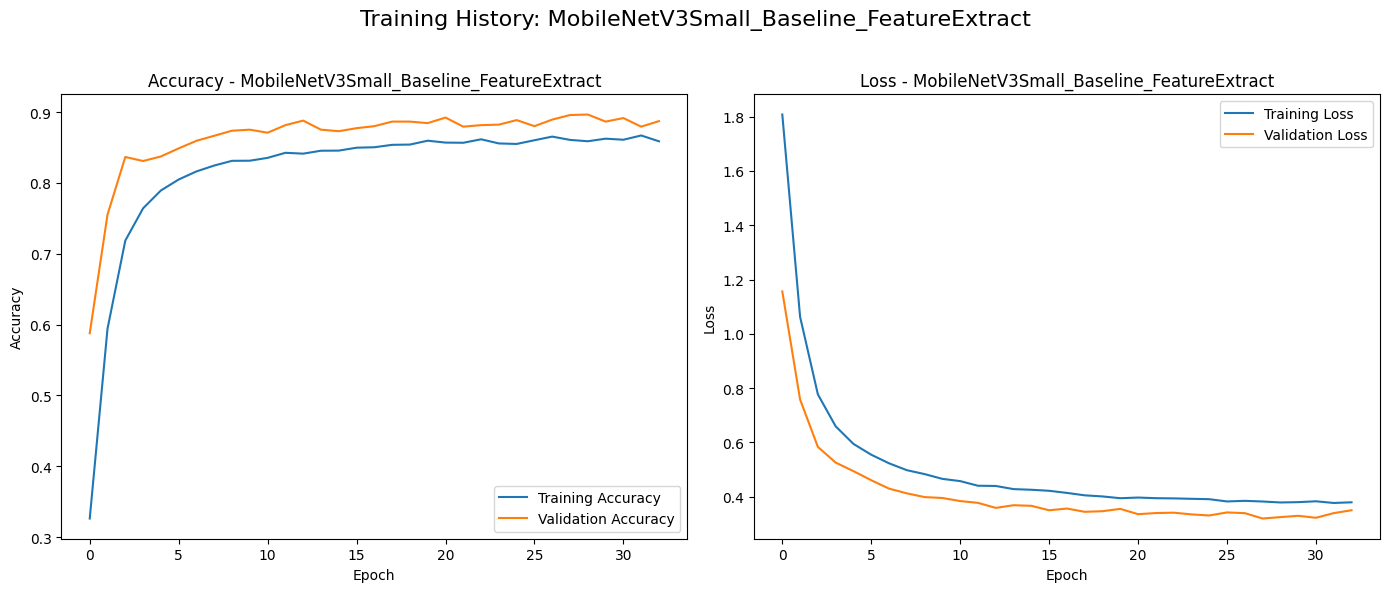


--- Mengevaluasi MobileNetV3Small_Baseline_FeatureExtract pada Test Set ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8841 - loss: 0.2739
Test Loss (MobileNetV3Small_Baseline_FeatureExtract): 0.2700
Test Accuracy (MobileNetV3Small_Baseline_FeatureExtract): 0.8927
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step

Laporan Klasifikasi untuk MobileNetV3Small_Baseline_FeatureExtract:
              precision    recall  f1-score   support

   buildings       0.89      0.86      0.88       437
      forest       0.99      1.00      0.99       474
     glacier       0.86      0.79      0.83       553
    mountain       0.83      0.84      0.84       525
         sea       0.91      0.96      0.94       510
      street       0.88      0.91      0.89       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000


Confusion Matrix untuk MobileNetV3Small_Baseline_FeatureExtract:
Grafi

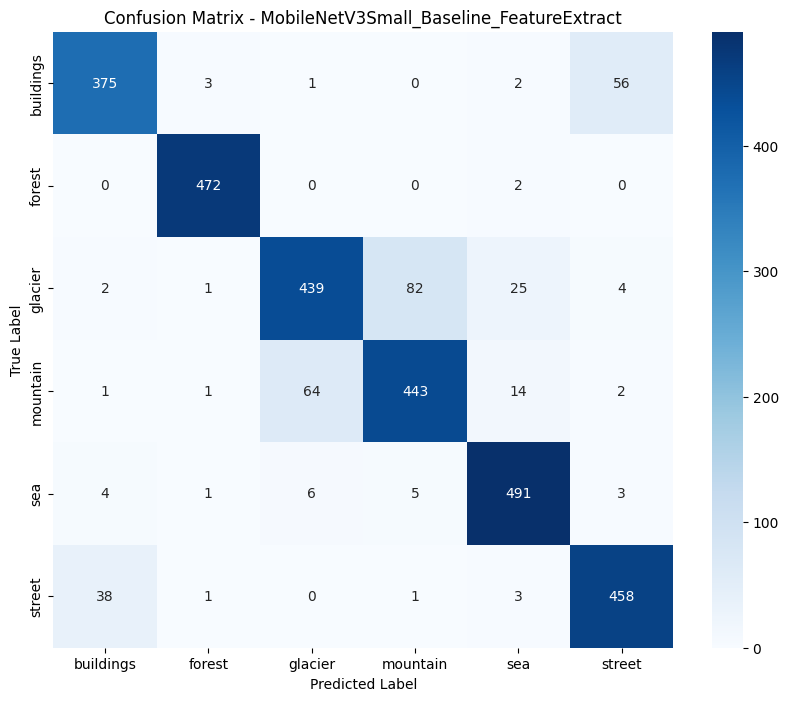

Model MobileNetV3Small_Baseline_FeatureExtract telah disimpan ke: results/model/baseline/mobilenetv3small_baseline_featureextract.keras

============================== Selesai memproses: MobileNetV3Small_Baseline_FeatureExtract ==============================


============================== Memproses Model: MobileNetV3Large_Baseline_FeatureExtract ==============================
Semua layer di base model 'MobileNetV3Large' telah dibekukan (trainable=False).

Memulai pelatihan untuk MobileNetV3Large_Baseline_FeatureExtract...
Epoch 1/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 70s 165ms/step - accuracy: 0.2976 - loss: 1.9746 - val_accuracy: 0.7282 - val_loss: 0.7666 - learning_rate: 1.0000e-04
Epoch 2/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.6921 - loss: 0.8228 - val_accuracy: 0.8338 - val_loss: 0.5022 - learning_rate: 1.0000e-04
Epoch 3/50
395/395 ━━━━━━━━━━━━━━━━━━━━ 58s 147ms/step - accuracy: 0.7891 - loss: 0.5816 - val_accuracy: 0.8688 - val_loss: 0.4123 - learning_rate: 1.00

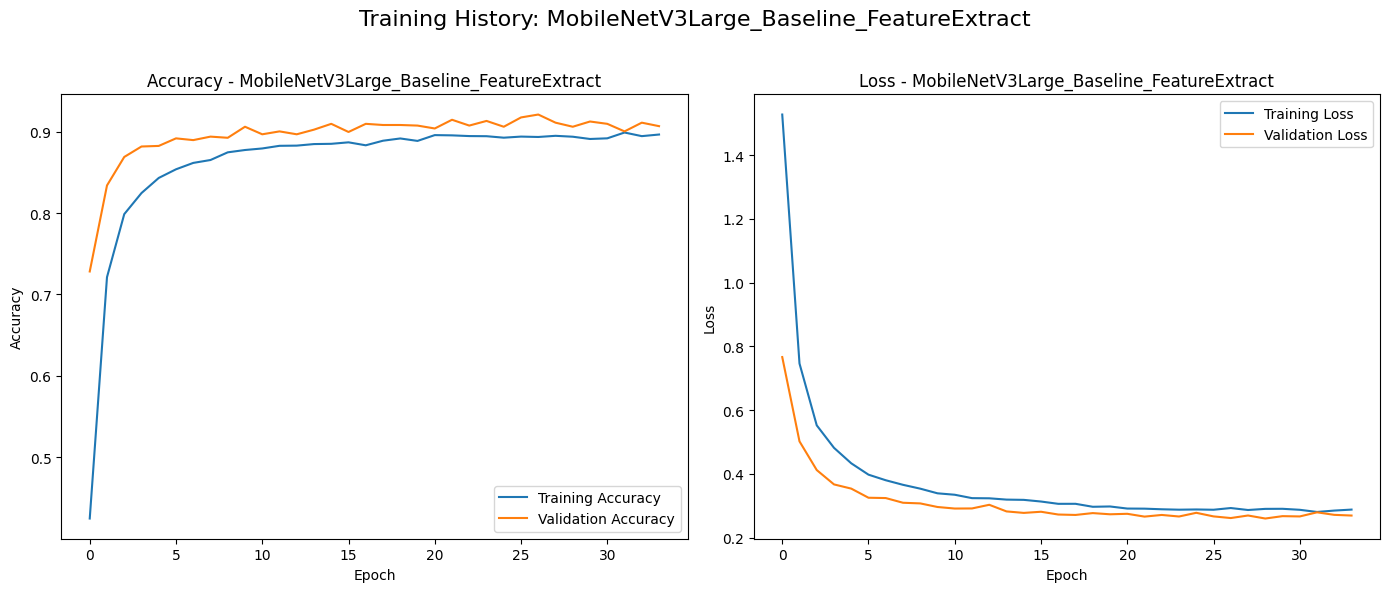


--- Mengevaluasi MobileNetV3Large_Baseline_FeatureExtract pada Test Set ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.9167 - loss: 0.2277
Test Loss (MobileNetV3Large_Baseline_FeatureExtract): 0.2310
Test Accuracy (MobileNetV3Large_Baseline_FeatureExtract): 0.9153
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step

Laporan Klasifikasi untuk MobileNetV3Large_Baseline_FeatureExtract:
              precision    recall  f1-score   support

   buildings       0.92      0.91      0.91       437
      forest       0.99      0.99      0.99       474
     glacier       0.87      0.84      0.85       553
    mountain       0.88      0.84      0.86       525
         sea       0.93      0.99      0.96       510
      street       0.92      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.91      0.92      0.91      3000


Confusion Matrix untuk MobileNetV3Large_Baseline_FeatureExtract:
Grafi

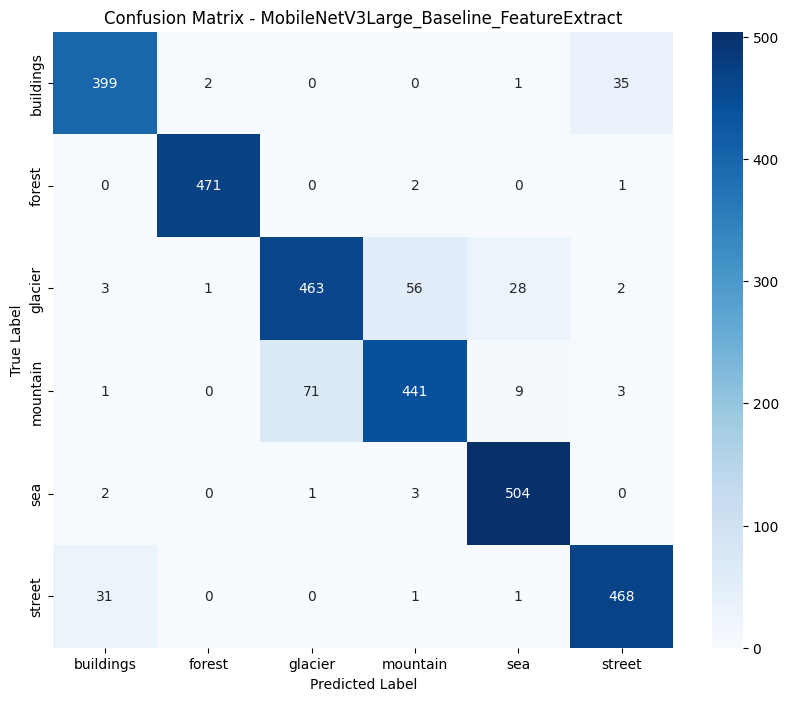

Model MobileNetV3Large_Baseline_FeatureExtract telah disimpan ke: results/model/baseline/mobilenetv3large_baseline_featureextract.keras

============================== Selesai memproses: MobileNetV3Large_Baseline_FeatureExtract ==============================


Semua model baseline telah diproses.


In [23]:
MODEL_VARIANTS = [
    ("MobileNetV3Small", MobileNetV3Small),
    ("MobileNetV3Large", MobileNetV3Large)
]

class_labels_for_eval = list(train_generator.class_indices.keys())


for model_name_prefix, model_function in MODEL_VARIANTS:
    current_model_name = f"{model_name_prefix}_Baseline_FeatureExtract"
    print(f"\n\n{'='*30} Memproses Model: {current_model_name} {'='*30}")

    # --- 1. Load Base Model ---
    base_model = model_function(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
    )

    base_model.trainable = False
    print(f"Semua layer di base model '{model_name_prefix}' telah dibekukan (trainable=False).")

    # --- 2. Kustom Head (Tanpa hidden Dense) ---
    x = base_model.output
    x = GlobalAveragePooling2D(name=f"{model_name_prefix}_gap")(x)
    x = Dropout(0.3, name=f"{model_name_prefix}_dropout")(x)
    predictions = Dense(NUM_CLASSES, activation='softmax', name=f"{model_name_prefix}_predictions")(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # --- 3. Kompilasi Model ---
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # --- 4. Callbacks ---
    earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
    checkpoint_cb = ModelCheckpoint(
        os.path.join(MODEL_BASELINE_DIR, f"{current_model_name.lower()}.keras"),
        save_best_only=True,
        monitor='val_accuracy',
        mode='max'
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        verbose=1,
        min_lr=1e-7
    )

    # --- 5. Pelatihan Model ---
    print(f"\nMemulai pelatihan untuk {current_model_name}...")
    history = model.fit(
        train_generator,
        epochs=EPOCHS,
        validation_data=validation_generator,
        callbacks=[earlystop, checkpoint_cb, reduce_lr]
    )
    print(f"Pelatihan {current_model_name} selesai.")

    # --- 6. Visualisasi dan Evaluasi ---
    plot_and_save_training_history(history, current_model_name, GRAPH_BASELINE_DIR)

    test_generator.reset()
    evaluate_model_and_save_cm(model, current_model_name, test_generator, class_labels_for_eval, GRAPH_BASELINE_DIR)

    # --- 9. Simpan Model dalam Format .keras ---
    model_save_filename = f"{current_model_name.replace(' ', '_').lower()}.keras"
    model_save_path = os.path.join(MODEL_BASELINE_DIR, model_save_filename)
    model.save(model_save_path)
    print(f"Model {current_model_name} telah disimpan ke: {model_save_path}")

    print(f"\n{'='*30} Selesai memproses: {current_model_name} {'='*30}")

print("\n\nSemua model baseline telah diproses.")